# Fit ellipses

## Imports

In [1]:
# Python standard library
import sys
import csv
import os
import importlib 
# Scientific computing

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.ndimage
import sklearn.mixture

#plt.rc('text', usetex=True)
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

# Program specific
PORE_STATS_BASE_DIRECTORY = os.getcwd().replace('notebooks', 'repo')
sys.path.append(PORE_STATS_BASE_DIRECTORY)


import optical_imaging as oi
import oi_file
import image_processing 

%load_ext autoreload
%autoreload 2

## Load data

In [177]:
#### Define file path
#data_base_path = oi_file.data_base_path
data_base_path = 'D:/'
date = '10-8-20'
particle_type = '/hl60d'
channel_type = '/25_50_25x150'
file_index = '1'



file_path = data_base_path + date + particle_type + channel_type + '/oi/'+ file_index+ '/bin/test_camera_0.raw'

#file_path = data_base_path + date + particle_type + channel_type + '/oi/'+ file_index+ '/bin/frames/frames.txt'


# Set output file path
output_file_path = data_base_path + date + particle_type + channel_type + '/oi/' + file_index + '/events/test_camera_0' + '_events.json'

# Open video
res_x = 880
res_y = 140
fps = 11103
exp = 1.5
camera = 0

## camera = 0 is raw 16bpp chronos
oi_vid = oi_file.Video(file_path, res_x, res_y, fps, exp,camera=camera)

# Load events
oi_events = oi_file.open_event_file_json(output_file_path)

print 'loaded', len(oi_events), 'oi events'

loaded 280 oi events


In [178]:
def plot_frame(frame, show = True):
    plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none',vmin=0,vmax=frame.max())
    if show:
        plt.show()
    
def plot_processed_over_raw(processed_frame, frame, show = True):
    green_processed_frame = np.zeros((processed_frame.shape[0], processed_frame.shape[1], 3))
    green_processed_frame[:,:,1] = processed_frame

    plt.imshow(frame, cmap = 'gray', origin = 'lower', alpha = 1, interpolation = 'none')
    plt.imshow(green_processed_frame, cmap = 'gray', origin = 'lower', alpha = 0.15, interpolation = 'none')

    if show:
        plt.show()
    
def plot_frame_hist(frame, show = True):
    plt.hist(frame.flatten(), facecolor = 'k', bins = 100)
    
    if show:
        plt.show()
    
def plot_all(processed_frame, frame):
    fig, axes = plt.subplots(1,3,figsize = (12,3))
    
    # Plot 1
    plt.sca(axes[0])
    plot_frame(processed_frame, show = False)
    
    
    # Plot 2
    plt.sca(axes[1])
    plot_processed_over_raw(processed_frame, frame, show = False)
    
    # Plot 3
    plt.sca(axes[2])
    plot_frame_hist(processed_frame, show = False)
    
    plt.show()

# Create stage

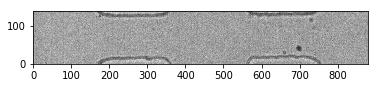

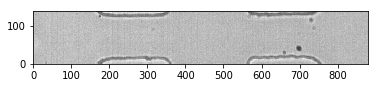

In [179]:
template_index = 100
template_frame = oi_vid.get_frame(template_index,camera=camera)
plot_frame(template_frame,(1,1))

num_avg = 5
template_frame_avg = np.zeros((res_y,res_x,num_avg))
for i in range(num_avg):
    template_frame_avg[:,:,i] = oi_vid.get_frame(template_index+i,camera=camera)

template_frame = template_frame_avg.mean(2)
plot_frame(template_frame)

D:/10-8-20/hl60d/25_50_25x150/oi/1/stage/stage_0.txt
[[180, 125], [180, 20], [730, 20], [730, 125]]
[-0.  1.]


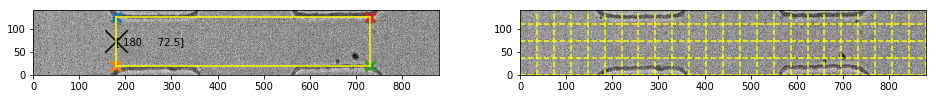

In [180]:
reload(oi)
template_index =100
template_frame = oi_vid.get_frame(template_index,camera=camera)
 
stage_file_path = data_base_path + date + particle_type + channel_type + '/oi/'+ file_index + '/stage/stage_0.txt' 
print stage_file_path
cs = oi.load_stage_file(stage_file_path)
print cs
c0 = cs[0]
c1 = cs[1]
c2 = cs[2]
c3 = cs[3]

oi_stage = oi.Stage(template_frame, c0, c1, c2, c3)
oi_stage._length_microns = 150
oi_stage.plot_stage()

In [181]:
def process_frame(frame, template_frame, detection, debug = False):
    
    processed_frame = np.copy(frame)
    processed_template_frame = np.copy(template_frame)
    
    # Crop
    function = crop_step['function']
    kwargs = crop_step['kwargs']            
    kwargs['x'] = detection._px
    kwargs['y'] = detection._py
    processed_frame = function(processed_frame, **kwargs)
    processed_template_frame = function(processed_template_frame, **kwargs)
    cropped_frame = np.copy(processed_frame)
    
    if debug:
        print function.__name__, kwargs
        #plot_all(processed_frame, cropped_frame)
    
    
    # Pre-negative steps
    for prenegative_step in prenegative_steps:
        function = prenegative_step['function']
        kwargs = prenegative_step['kwargs']
        
        processed_frame = function(processed_frame, **kwargs)
        processed_template_frame = function(processed_template_frame, **kwargs)
        
        if debug:
            print function.__name__, kwargs
            plot_all(processed_frame, cropped_frame)
        
    # Negative step
    function = negative_step['function']
    kwargs = negative_step['kwargs']
    processed_frame = function(processed_frame, processed_template_frame, **kwargs)
    
    if debug:
        print function.__name__, kwargs
        plot_all(processed_frame, cropped_frame)
        
    # Post-negative steps
    for postnegative_step in postnegative_steps:
        function = postnegative_step['function']
        kwargs = postnegative_step['kwargs']
        
        processed_frame = function(processed_frame, **kwargs)
        
        if debug:
            print function.__name__, kwargs
            plot_all(processed_frame, cropped_frame)
            
    return processed_frame
  
def fit_plot_ellipse(frame, processed_frame, crop_distance, detection, detection_index, debug = False):

    # Ellipse-fitting
    
    
    ellipse_pixels = np.where(processed_frame == 1)
        
    ellipse = oi.fit_ellipse_image_aligned(ellipse_pixels[1], ellipse_pixels[0])
    
    
    # Get ellipse parameters
    ellipse_x, ellipse_y = oi.get_ellipse_center(ellipse)
    ellipse_a, ellipse_b = oi.get_ellipse_axes_lengths(ellipse)
    ellipse_theta = oi.get_ellipse_angle(ellipse)
    
    cropped_frame = image_processing.crop_frame(frame, detection._px, detection._py, crop_distance)
    
    
    # Plot
    
    if debug:
        fig, axes = plt.subplots(1,3,figsize = (12,6))

        green_processed_frame = np.zeros((processed_frame.shape[0], processed_frame.shape[1], 3))
        green_processed_frame[:,:,1] = np.copy(processed_frame)
        




        fig.sca(axes[0])
        plt.imshow(cropped_frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
        
        plt.xticks([])
        plt.yticks([])


        fig.sca(axes[1])
        plt.imshow(cropped_frame, interpolation = 'none', origin = 'lower', alpha = 1., cmap = 'gray')
        plt.imshow(green_processed_frame, interpolation = 'none', origin = 'lower', alpha = 0.5)
        
        plt.xticks([])
        plt.yticks([])

        fig.sca(axes[2])
        plt.imshow(cropped_frame, interpolation = 'none', origin = 'lower', alpha = 1., cmap = 'gray')
        plt.imshow(green_processed_frame, interpolation = 'none', origin = 'lower', alpha = 0.5)
        
        plt.xticks([])
        plt.yticks([])
        
        
        num_points = 100
        xs = []
        ys = []
        for i in range(num_points):
            angle = i*2*np.pi/99.
            temp_x = ellipse_a*np.cos(angle)
            temp_y = ellipse_b*np.sin(angle)
            xs.append(ellipse_x + np.cos(ellipse_theta)*temp_x + np.sin(ellipse_theta)*temp_y)
            ys.append(ellipse_y + np.sin(ellipse_theta)*temp_x - np.cos(ellipse_theta)*temp_y)
            
            
        plt.plot(xs, ys, ls = '--', c = 'white', lw = 1)
        
        plt.text(0, 1.0, 'a/b=' + str(round(ellipse_a/ellipse_b, 2)), transform = plt.gca().transAxes,\
                 color = 'white', fontweight = 'bold', size = 24, ha = 'left', va = 'top')
        
        plt.xlim(0, cropped_frame.shape[1] - 1)
        plt.ylim(0, cropped_frame.shape[0] - 1)
            
            


        plt.show()
    
    
    
    
    ellipse_x = ellipse_x + detection._px - crop_distance
    ellipse_y = ellipse_y + detection._py - crop_distance
    
    
    return [detection_index, ellipse_x, ellipse_y, ellipse_a, ellipse_b, ellipse_theta]
        
    
        

In [182]:
def shell_contour(processed_frame,detection,crop_distance,index):
    
    i = index
    xs_shell = np.where(processed_frame==1)[1]+int(detection._px)-crop_distance
    ys_shell = np.where(processed_frame==1)[0]+int(detection._py)-crop_distance
    
    xc_shell = xs_shell.mean()
    yc_shell = ys_shell.mean()
    
    centroid = [xc_shell,yc_shell]
    
    #cord_shell = np.asarray([list(a) for a in zip(xs_shell,ys_shell)])
    
    return [i,centroid,list(xs_shell),list(ys_shell)]

## Find event to test fit on

##### Frame

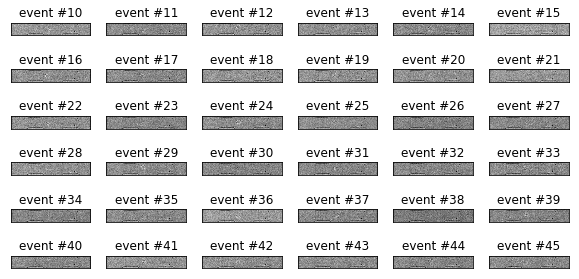

In [183]:
fig, axes = plt.subplots(6,6,figsize = (10,5))
start_index = 1*10

for i in range(36):
    oi_index = start_index + i
    oi_event = oi_events[oi_index]
    ts = oi_event.get_tf()
    t = int((ts[-1] + ts[0])/2.)
    frame = oi_vid.get_frame(t,camera=camera)
    
    
    row = i/6
    column = i%6
    plt.sca(axes[row, column])
    plt.imshow(frame, cmap = 'gray', origin = 'lower')
    plt.title('event #' + str(i + start_index))
    plt.xticks([])
    plt.yticks([])
plt.show()

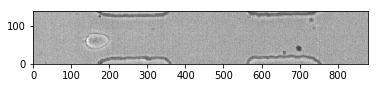

In [184]:
e = 45
plot_frame(image_processing.gaussian_blur(oi_vid.get_frame(oi_events[e]._detections[14]._tf),(3,3)))

## Define ellipse fitting functions

In [185]:
from skimage.filters import threshold_otsu, threshold_adaptive,threshold_local,rank
from skimage.morphology import *
from skimage.measure import *
from skimage.filters import roberts, sobel, scharr, prewitt
from scipy.spatial import ConvexHull

raw_frame


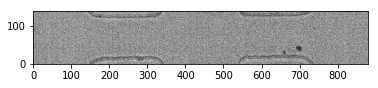

neg


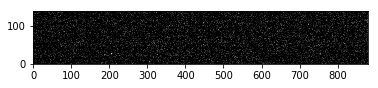

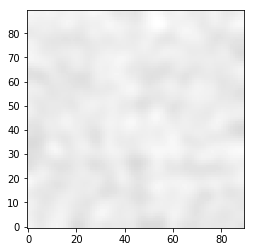

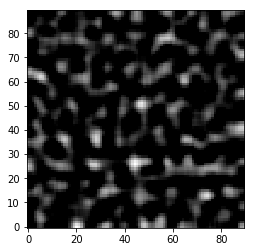

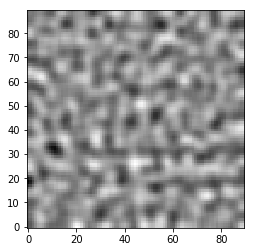

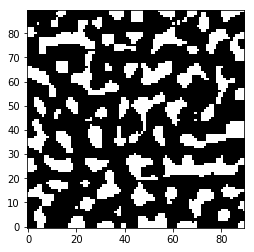

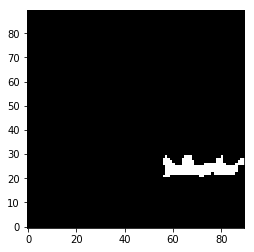

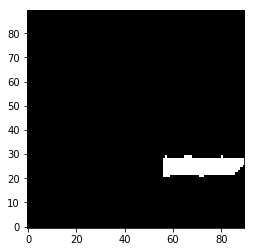

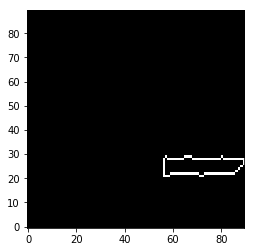

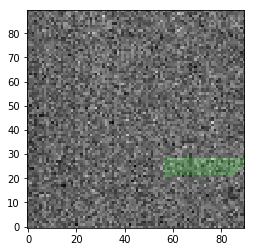

raw_frame


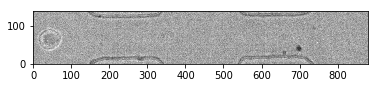

neg


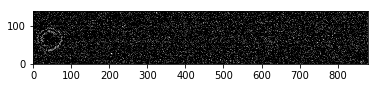

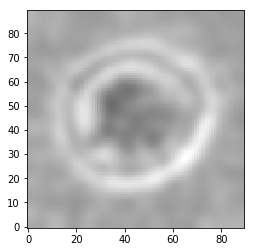

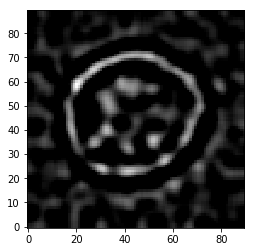

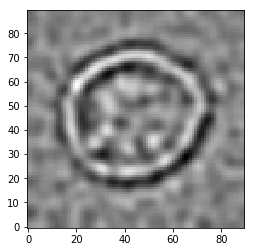

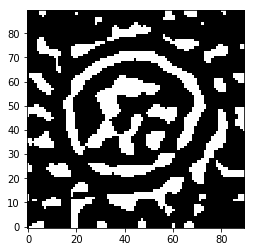

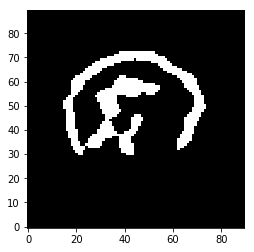

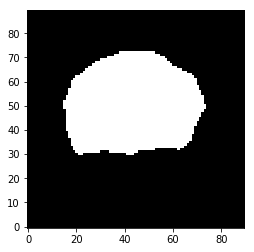

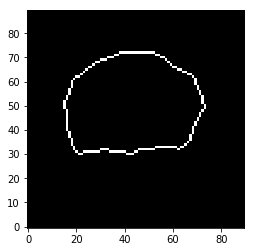

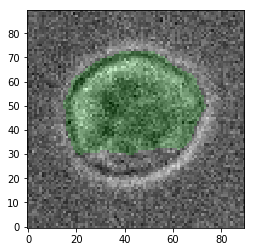

raw_frame


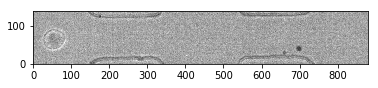

neg


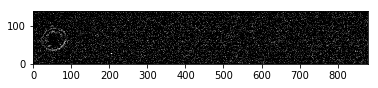

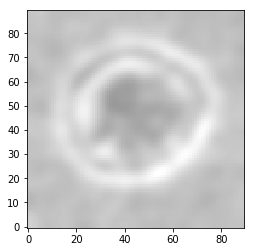

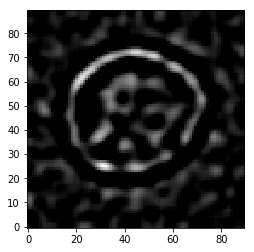

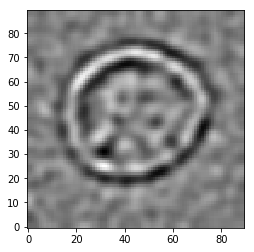

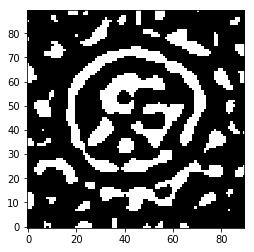

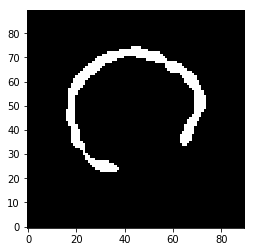

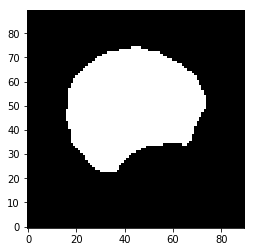

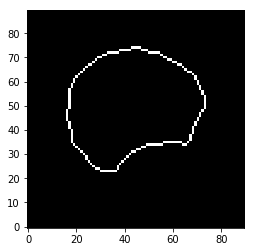

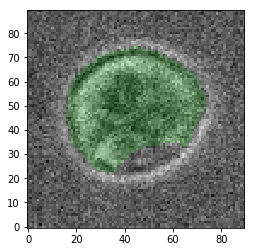

raw_frame


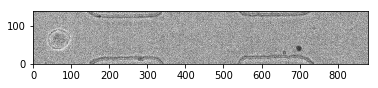

neg


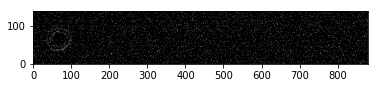

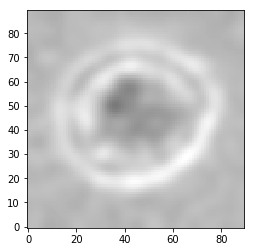

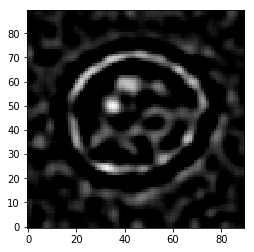

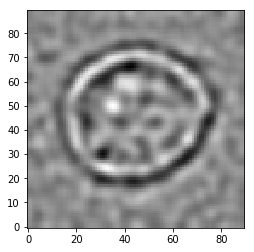

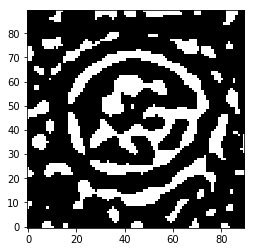

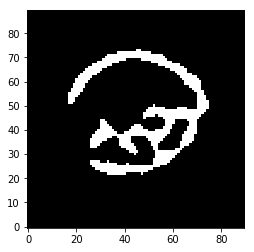

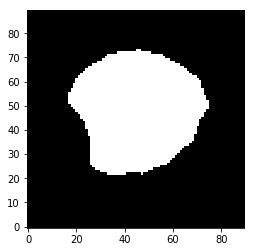

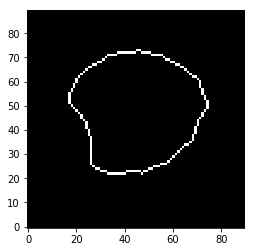

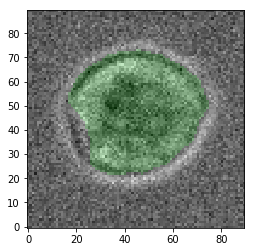

In [94]:
oi_index = 70
oi_event = oi_events[oi_index]
xc_left = -30
xc_right = -20
for j, detection in enumerate(oi_event._detections):
    try:
        x = int(detection._px)
        y = int(detection._py)
        xc, yc = oi_stage.get_channel_coordinates(x, y)
        xc = oi_stage.pixels_to_meters(xc)
        
        if xc >= xc_left and xc <= xc_right:
            det = oi_event._detections[j]
            x = int(det._px)
            y = int(det._py)
            xc,yc = oi_stage.get_channel_coordinates(x,y)
            xcm = oi_stage.pixels_to_meters(xc)
            tf = det._tf


            raw_frame = oi_vid.get_frame(tf,camera=camera)
            print('raw_frame')
            plot_frame(raw_frame)
            #gauss_frame_raw = image_processing.gaussian_blur(raw_frame,(15,15))
            #gauss_frame_temp = image_processing.gaussian_blur(template_frame,(15,15))
            neg_frame = (raw_frame-template_frame)
            #frame = template_frame-frame
            
            print('neg')
            plot_frame(neg_frame)


            crop_frame = image_processing.crop_frame(neg_frame,x,y,45)
            norm_frame = image_processing.normalize(crop_frame)
            gauss_frame = image_processing.gaussian_blur(norm_frame,(15,15))
            plot_frame(gauss_frame)
            grad_frame = image_processing.gradient(gauss_frame)
            plot_frame(grad_frame)
            norm2_frame = image_processing.normalize(grad_frame)
            plot_frame(norm2_frame)
            #threshold_difference = threshold_otsu(frame)
            #frame = (frame>threshold_difference)*1
            thresh_frame = image_processing.gaussian_threshold(norm2_frame,sigma_multiplier=.5)
            plot_frame(thresh_frame)
            cluster_frame = image_processing.largest_cluster(thresh_frame)
            plot_frame(cluster_frame)
            #frame = ip.invert(frame)
            #frame = binary_closing(frame,disk(5))
            closed_frame = image_processing.morphological_closing(cluster_frame,(45,45))


            plot_frame(closed_frame)
            shell = image_processing.erodesubtract(closed_frame,2)
            plot_frame(shell)
            plot_processed_over_raw(closed_frame,image_processing.crop_frame(raw_frame,x,y,45))
            
            
            xs_closed = np.where(closed_frame==1)[1]+int(det._px)-crop_distance
            ys_closed = np.where(closed_frame==1)[0]+int(det._py)-crop_distance
            
            cord_closed = np.asarray([list(a) for a in zip(xs_closed,ys_closed)])
            
            xs_shell = np.where(shell==1)[1]+int(det._px)-crop_distance
            ys_shell = np.where(shell==1)[0]+int(det._px)-crop_distance
            
            
            cord_shell = np.asarray([list(a) for a in zip(xs_shell,ys_shell)])
            
    except:
        pass

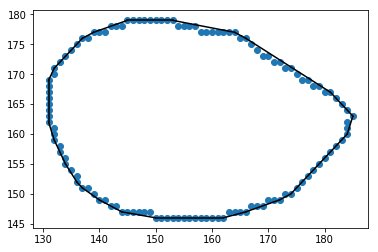

In [24]:
hull = ConvexHull(cord_shell)
plt.scatter(cord_shell[:,0],cord_shell[:,1])
for simplex in hull.simplices:
    plt.plot(cord_shell[simplex,0],cord_shell[simplex,1],'k-')

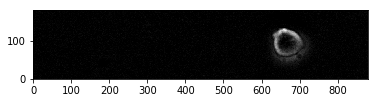

In [37]:
plot_frame(frame-template_frame)

crop_frame {'y': 60.34211644708882, 'crop_distance': 50, 'x': 285.92392690182743}
normalize {}


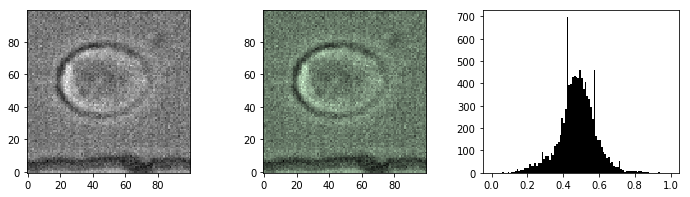

gaussian_blur {'blur_kernel': (11, 11)}


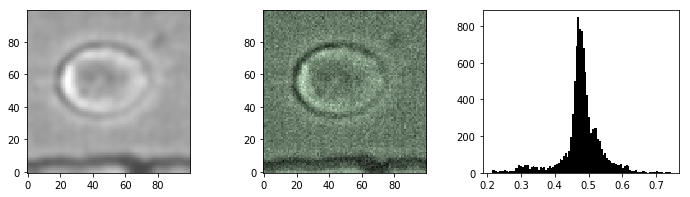

negative {'direction': 'pos', 'block': 25}


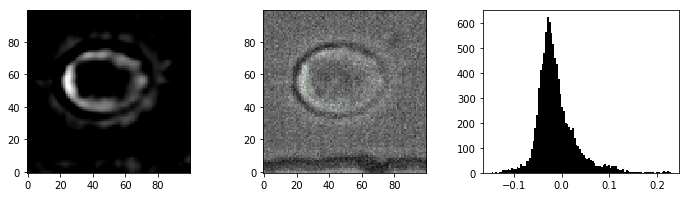

normalize {}


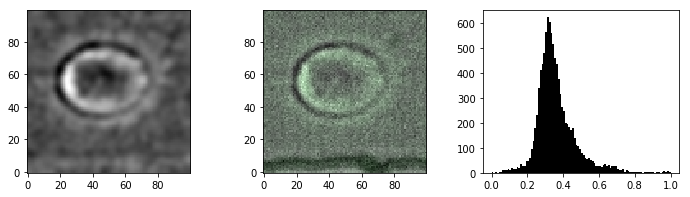

gaussian_threshold {'sigma_multiplier': 1.4}


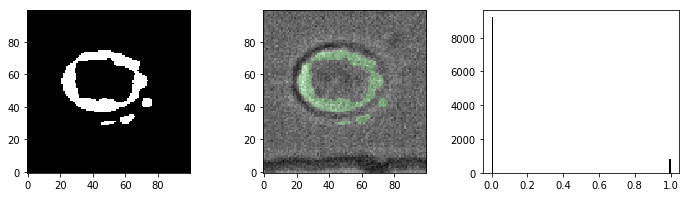

threshold_clusters {'cluster_threshold': 350}


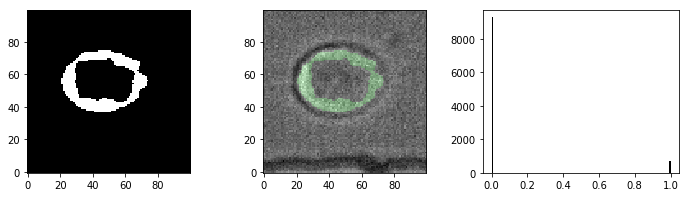

morphological_closing {'morph_kernel': (3, 3)}


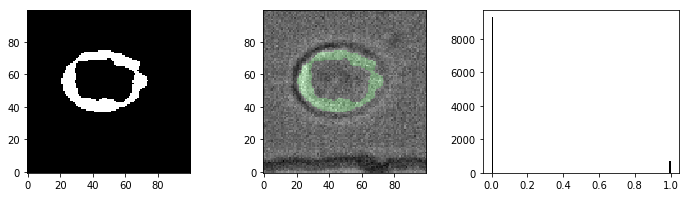

largest_cluster {}


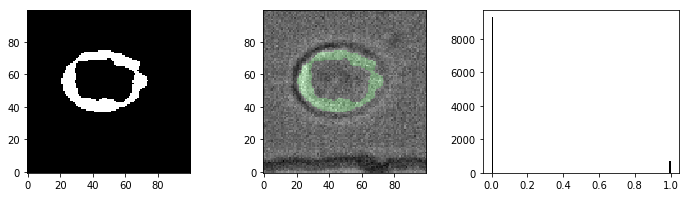

morphological_closing {'morph_kernel': (75, 75)}


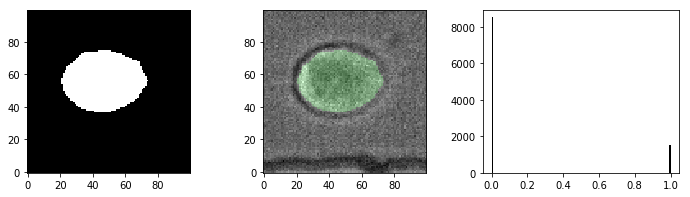

erodesubtract {'iterations': 2}


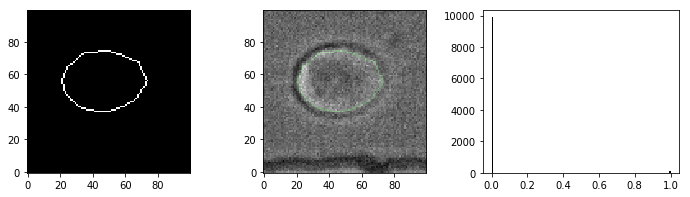

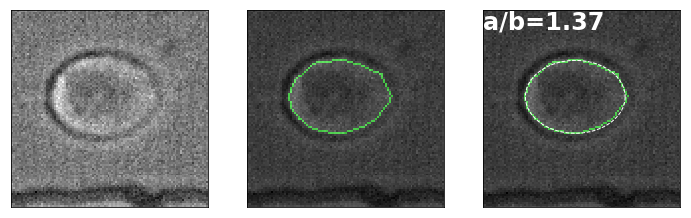

crop_frame {'y': 60.841016803102114, 'crop_distance': 50, 'x': 323.18569582076691}
normalize {}


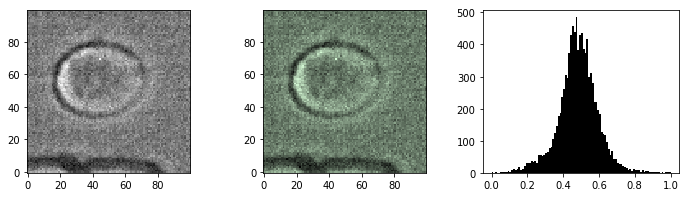

gaussian_blur {'blur_kernel': (11, 11)}


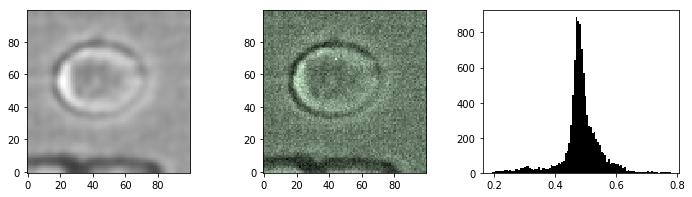

negative {'direction': 'pos', 'block': 25}


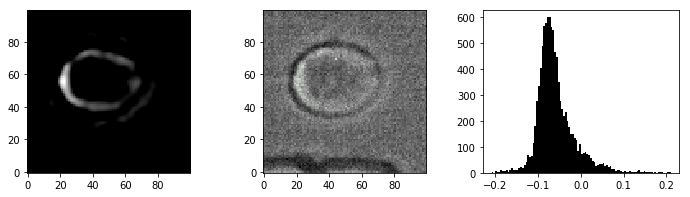

normalize {}


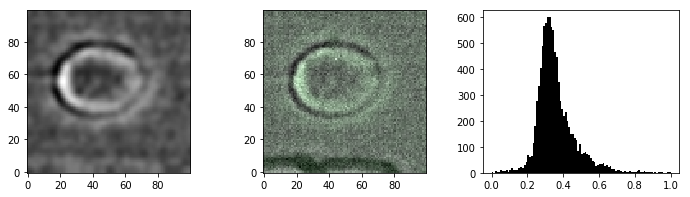

gaussian_threshold {'sigma_multiplier': 1.4}


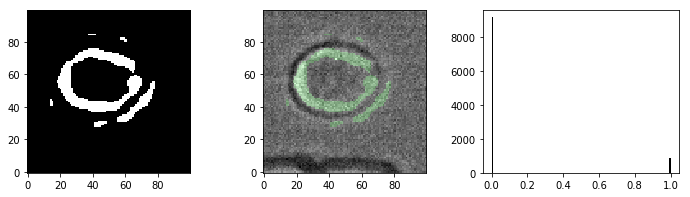

threshold_clusters {'cluster_threshold': 350}


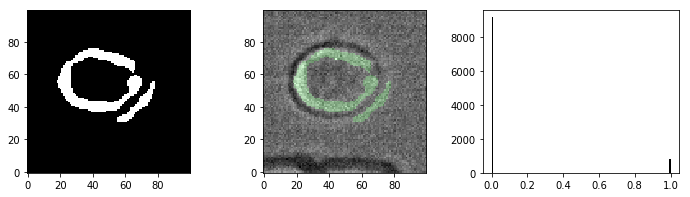

morphological_closing {'morph_kernel': (3, 3)}


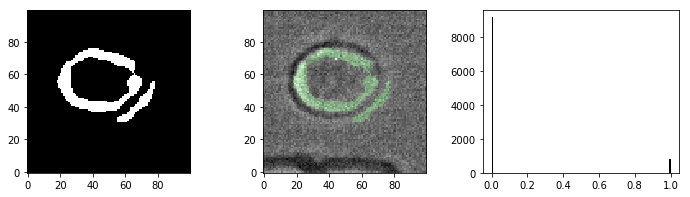

largest_cluster {}


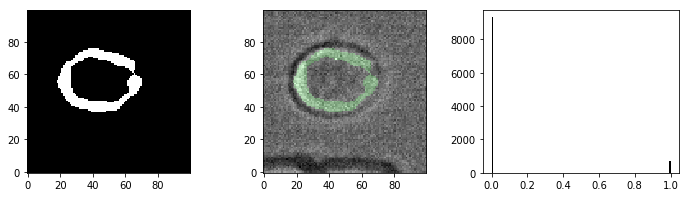

morphological_closing {'morph_kernel': (75, 75)}


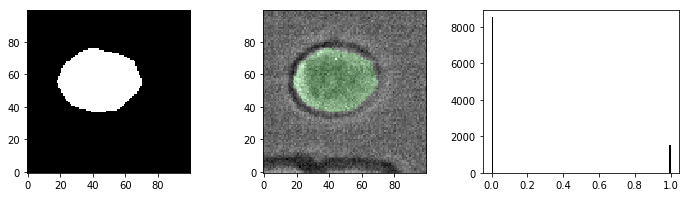

erodesubtract {'iterations': 2}


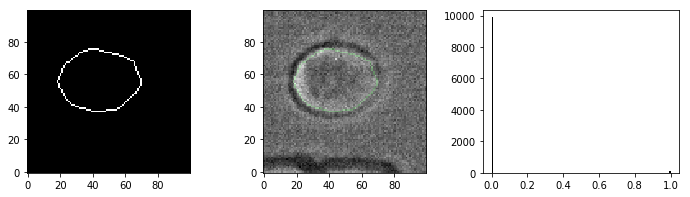

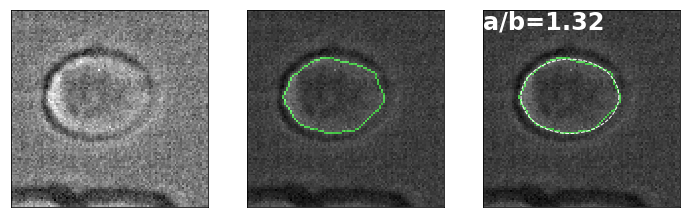

In [189]:
oi_index = 60
oi_event = oi_events[oi_index]
template_index = 100
xc_left = 20
xc_right = 40
for j, detection in enumerate(oi_event._detections):
    try:
        x = int(detection._px)
        y = int(detection._py)
        xc, yc = oi_stage.get_channel_coordinates(x, y)
        xc = oi_stage.pixels_to_meters(xc,camera=camera)
        if xc >= xc_left and xc <= xc_right:

            tf = detection._tf
            
            frame = oi_vid.get_frame(tf,camera=camera)
            template_frame = oi_vid.get_frame(template_index,camera=camera)
            
            crop_distance = 50
            crop_step = {'function': image_processing.crop_frame, 'kwargs': {'crop_distance': crop_distance}}
            
            prenegative_steps = []
            prenegative_steps.append({'function': image_processing.normalize, 'kwargs': {}})
            prenegative_steps.append({'function': image_processing.gaussian_blur, 'kwargs': {'blur_kernel': (11,11)}})

            
            negative_step = {'function': image_processing.negative, 'kwargs': {'direction':'pos','block': 25}}


            postnegative_steps = []
            postnegative_steps.append({'function': image_processing.normalize, 'kwargs': {}})
            #postnegative_steps.append({'function': image_processing.gaussian_blur, 'kwargs': {'blur_kernel': (5, 5)}})
            #postnegative_steps.append({'function': image_processing.gradient, 'kwargs': {}})
            #postnegative_steps.append({'function': image_processing.gaussian_blur, 'kwargs': {'blur_kernel': (11, 11)}})
            #postnegative_steps.append({'function': image_processing.invert, 'kwargs': {}})
            postnegative_steps.append({'function': image_processing.gaussian_threshold, 'kwargs': {'sigma_multiplier':1.4}})
            #postnegative_steps.append({'function':image_processing.morphological_opening,'kwargs':{'morph_kernel':(3,3)}})
            
            postnegative_steps.append({'function': image_processing.threshold_clusters, 'kwargs': {'cluster_threshold': 350}})
            postnegative_steps.append({'function': image_processing.morphological_closing, 'kwargs': {'morph_kernel': (3,3)}})
            postnegative_steps.append({'function': image_processing.largest_cluster, 'kwargs': {}})
            
            postnegative_steps.append({'function': image_processing.morphological_closing, 'kwargs': {'morph_kernel': (75,75)}})
            postnegative_steps.append({'function': image_processing.erodesubtract, 'kwargs': {'iterations':2}})

            processed_frame = process_frame(frame, template_frame, detection, debug = True)
            fit_plot_ellipse(frame, processed_frame, crop_distance, detection, j, debug = True)
            


        
    except:
        print 'failed on ', j, len(oi_event._detections)
        exc_type, exc_obj, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        print(exc_type, fname, exc_tb.tb_lineno)
        pass
    
        

## Save fit

In [190]:
def out_of_bounds(detection,crop):
    x_min = crop
    x_max = res_x - crop
    
    y_min = crop
    y_max = res_y - crop
    
    
    out = False
    if detection._px < x_min:
        out = True
        
    if detection._px > x_max:
        out = True
        
    if detection._py < y_min:
        out = True
        
    if detection._py > y_max:
        out = True
    
    
    return out

In [191]:
ellipsess = []
contourss = []
for i, oi_event in enumerate(oi_events):
    print 'i = ', i, '/', len(oi_events)

    ellipsess.append([])
    ellipses = ellipsess[-1]
    
    contourss.append([])
    contours = contourss[-1]
    
    
    for j, detection in enumerate(oi_event._detections):
        try:

            
            if out_of_bounds(detection,crop_distance) == False:


                
                tf = detection._tf

                frame = oi_vid.get_frame(tf)
                template_frame = oi_vid.get_frame(template_index)


                processed_frame = process_frame(frame, template_frame, detection, debug = False)
                ellipse = fit_plot_ellipse(frame, processed_frame, crop_distance, detection, j, debug = False)
                contour = shell_contour(processed_frame,detection,crop_distance,j)
        
                ellipses.append(ellipse)
                contours.append(contour)
        
        
        except:
            #print 'failed on ', j, len(oi_event._detections)
            exc_type, exc_obj, exc_tb = sys.exc_info()
            fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
            #print(exc_type, fname, exc_tb.tb_lineno)
            pass



i =  0 / 280
i =  1 / 280
i =  2 / 280
i =  3 / 280
i =  4 / 280
i =  5 / 280
i =  6 / 280
i =  7 / 280
i =  8 / 280
i =  9 / 280
i =  10 / 280
i =  11 / 280
i =  12 / 280
i =  13 / 280
i =  14 / 280
i =  15 / 280
i =  16 / 280
i =  17 / 280
i =  18 / 280
i =  19 / 280
i =  20 / 280
i =  21 / 280
i =  22 / 280
i =  23 / 280
i =  24 / 280
i =  25 / 280
i =  26 / 280
i =  27 / 280
i =  28 / 280
i =  29 / 280
i =  30 / 280
i =  31 / 280
i =  32 / 280
i =  33 / 280
i =  34 / 280
i =  35 / 280
i =  36 / 280
i =  37 / 280
i =  38 / 280
i =  39 / 280
i =  40 / 280
i =  41 / 280
i =  42 / 280
i =  43 / 280
i =  44 / 280
i =  45 / 280
i =  46 / 280
i =  47 / 280
i =  48 / 280
i =  49 / 280
i =  50 / 280
i =  51 / 280
i =  52 / 280
i =  53 / 280
i =  54 / 280
i =  55 / 280
i =  56 / 280
i =  57 / 280
i =  58 / 280
i =  59 / 280
i =  60 / 280
i =  61 / 280
i =  62 / 280
i =  63 / 280
i =  64 / 280
i =  65 / 280
i =  66 / 280
i =  67 / 280
i =  68 / 280
i =  69 / 280
i =  70 / 280
i =  71 / 280
i 

## Save

In [192]:
#output_base_path = 'C:/Users/codyt/Documents/cell_data/analysis/'
output_base_path = 'D:/analysis/'
#output_base_path = oi_file.ellipse_base_path
output_file_path = output_base_path + date + '/' + particle_type + channel_type + '/' + file_index + '/' + 'ellipses.txt'
output_file_path2 = output_base_path + date + '/' + particle_type + channel_type + '/' + file_index + '/' + 'contours.txt'
print output_file_path

D:/analysis/10-8-20//hl60d/25_50_25x150/1/ellipses.txt


In [193]:
preprocessing_steps = []

for step in [crop_step] + prenegative_steps + [negative_step] + postnegative_steps:
    preprocessing_steps.append([step['function'].__name__, step['kwargs']])
    
print preprocessing_steps

[['crop_frame', {'y': 50.084484420173467, 'crop_distance': 50, 'x': 816.06135560552525}], ['normalize', {}], ['gaussian_blur', {'blur_kernel': (11, 11)}], ['negative', {'direction': 'pos', 'block': 25}], ['normalize', {}], ['gaussian_threshold', {'sigma_multiplier': 1.4}], ['threshold_clusters', {'cluster_threshold': 350}], ['morphological_closing', {'morph_kernel': (3, 3)}], ['largest_cluster', {}], ['morphological_closing', {'morph_kernel': (75, 75)}], ['erodesubtract', {'iterations': 2}]]


In [194]:
with open(output_file_path, 'w') as file_handle:
    file_writer = csv.writer(file_handle, delimiter = '\t')
    
    # Write preprocessing steps
    file_writer.writerow(preprocessing_steps)
    
    # Write ellipse info
    file_writer.writerow(['detection index', 'ellipse center x', 'ellipse center y', 'ellipse axes x', 'ellipse axes y', 'ellipse angle'])
    
    # Write ellipse
    for i, ellipses in enumerate(ellipsess):
        file_writer.writerow(['event #', i])
        for ellipse in ellipses:
            file_writer.writerow(ellipse)

In [195]:
with open(output_file_path2,'w') as file_handle:
    file_writer = csv.writer(file_handle, delimiter = '\t')
    
    # Write preprocessing steps
    file_writer.writerow(preprocessing_steps)
    
    file_writer.writerow(['detection index','centroid','xs_shell','ys_shell'])
    
    # Write contour
    for i, contours in enumerate(contourss):
        file_writer.writerow(['event #', i])
        for contour in contours:
            file_writer.writerow(contour)

In [ ]:
#reload(image_processing)
#blur_kernel = (15,15)
#template_index = 100
oi_index = 11
oi_event = oi_events[oi_index]

index = 10
tf=oi_event._detections[index]._tf
raw_frame = oi_vid.get_frame(tf,camera=camera)

#template_frame = preprocess_frame(oi_vid.get_frame(template_index,camera=camera),blur_kernel)
frame = preprocess_frame(raw_frame,blur_kernel)

x = oi_event._detections[index]._px
y = oi_event._detections[index]._py

test_frame = frame - template_frame
thresh = threshold_otsu(test_frame)
bw = closing(test_frame>thresh,square(3))

cleared = clear_border(bw)
label_image = label(cleared,connectivity=2)
image_label_overlay = label2rgb(label_image,image=test_frame)

#cnts, hierarchy= cv2.findContours(bw*1,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(2,2,figsize=(16,8))

# Raw image
plt.sca(axes[0,0])
plt.imshow(frame, cmap = 'gray', origin = 'lower')


# Negative
plt.sca(axes[0,1])
plt.imshow(neg_frame, cmap = 'gray', origin = 'lower')



# Thresholded negative
plt.sca(axes[1,0])
plt.imshow(temp_neg_frame, vmin = 0, vmax = 1, cmap = 'gray', origin = 'lower')

# Color frame
color_frame = np.zeros((frame.shape[0], frame.shape[1], 3))
for cluster in clusters:
    rand_color = [np.random.rand(), np.random.rand(), np.random.rand()]
    for pixel in cluster:
        color_frame[pixel[0], pixel[1],:] = rand_color

plt.sca(axes[1,1])
plt.imshow(raw_frame, cmap = 'gray', origin = 'lower')
plt.imshow(color_frame, alpha = 0.55, origin = 'lower')


plt.show()